# Training 3D U-Net model for multi-class semantic segmentation

### Install pkgs

In [12]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
#!pip install -q "monai-weekly[mlflow]"
#!pip install git+https://github.com/copick/copick-utils.git

### Copick configuration file template

We will use a Polenet simulation dataset 10439 from the [CryoET Data Portal](https://cryoetdataportal.czscience.com) in this notebook. The dataset has 27 tomograms and 7 celluar structures. We will use [copick](https://copick.github.io/copick/) dataset API for handling cryoET datasets. Below is a copick configuration file detailing the dataset, and you can save it as a JSON file in your working directory.

```
{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "LOCAL_PATH",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}

```

In [1]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    CropForegroundd, 
    Orientationd, 
    Spacingd, 
    EnsureTyped, 
    Activations, 
    AsDiscrete, 
    Resized, 
    RandFlipd, 
    RandRotate90d, 
    RandZoomd,
    RandGridPatchd,
    NormalizeIntensityd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

## Prepare the dataset

### 1. Get copick root

In [2]:
copick_config_path = "config_10439.json"
root = copick.from_file(copick_config_path)

### 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [3]:
segmentation_from_picks(radius, painting_segmentation_name, run, voxel_spacing, tomo_type, pickable_object, pick_set, user_id="paintedPicks", session_id="0")

NameError: name 'segmentation_from_picks' is not defined

In [1]:
# from copick_utils.segmentation.segmentation_from_picks import segmentation_from_picks

# voxel_spacing = 10 
# tomo_type = "wbp"
# painting_segmentation_name = "paintedPicks"
# data_dicts = []
# paint_scale = 0.8  # how large the paint ball size wrt particle size

# for run in tqdm(root.runs):
#     for pickable_object in root.pickable_objects:
#         print(f"Painting {pickable_object.name}")
#         # radius = pickable_object.radius / voxel_spacing * paint_scale
#         radius = 10 
#         painting_segmentation_name = "paintedPicks"
#         try:
#             pick_set = run.get_picks(object_name=pickable_object.name, user_id="data-portal")[0]
#             # print(pick_set)
#             segmentation_from_picks(radius, painting_segmentation_name, run, voxel_spacing, tomo_type, pickable_object, pick_set, user_id="paintedPicks", session_id="0")
#             # print(binary_seg)
#         except:
#             pass  

### 3. Get tomograms and their segmentaion masks (from picks) arrays

This 10439 dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [3]:
def get_tomogram_array(copick_run, voxel_spacing=10, tomo_type='wbp'):
    voxel_spacing_obj = copick_run.get_voxel_spacing(voxel_spacing)
    tomogram = voxel_spacing_obj.get_tomogram(tomo_type)
    image = zarr.open(tomogram.zarr(), mode='r')['0']
    return image[:]

def get_segmentation_array(copick_run, segmentation_name, voxel_spacing=10, is_multilabel=True):
    seg = copick_run.get_segmentations(is_multilabel=is_multilabel, name=segmentation_name, voxel_size=voxel_spacing)
    if len(seg) == 0:
        raise ValueError(f"No segmentations found for session '{session_id}' and segmentation type '{segmentation_type}'.")
    segmentation = zarr.open(seg[0].zarr().path, mode="r")['0']
    return segmentation[:]

In [4]:
voxel_spacing = 10 
tomo_type = "wbp"
painting_segmentation_name = "remotetargets"

data_dicts = []
for run in tqdm(root.runs[:15]):
    tomogram = get_tomogram_array(run)
    segmentation = get_segmentation_array(run, painting_segmentation_name)
    data_dicts.append({"image": tomogram, "label": segmentation})

100%|███████████████████████████████████████████| 15/15 [02:30<00:00, 10.05s/it]


Since memebranes do not have picks, we should see 6 distinct labels for particles, with 0 being the default background label. 

In [7]:
print(np.unique(data_dicts[0]['label']))

[0 1 2 3 4 5 6 7]


### 4. Visualize the tomogram and painted segmentation from ground-truth picks

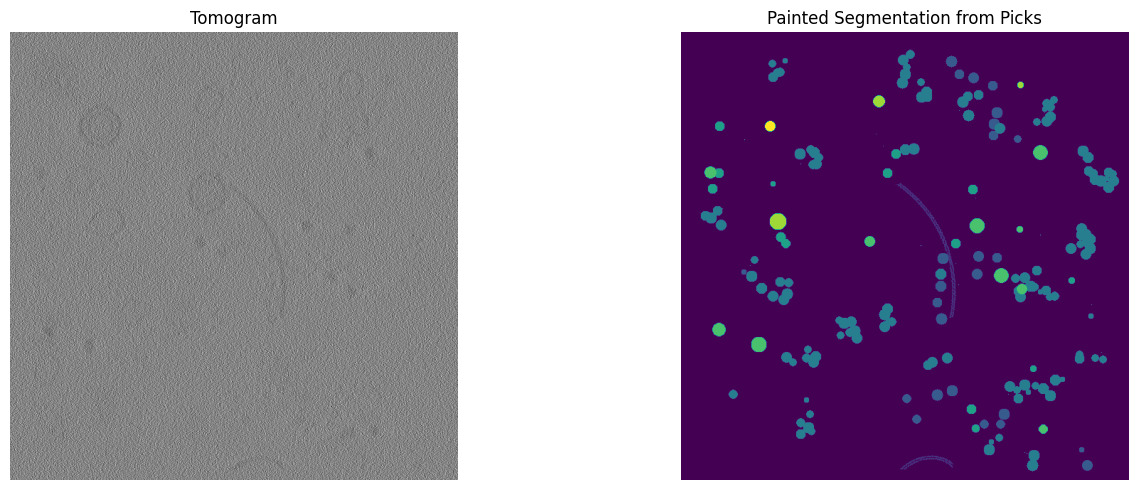

In [6]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][90],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][90], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Prepare dataloaders

In [5]:
# Define transforms for image and segmentation
transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(1, 2)),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandZoomd(keys=["image", "label"], prob=0.2, min_zoom=0.9, max_zoom=1.1),
    RandGridPatchd(keys=["image", "label"], patch_size=(96, 96, 96), patch_overlap=(32, 32, 32)),  # Tiling into patches 
])

/hpc/projects/group.czii/jonathan.schwartz/2024_czii_mlchallenge_notebooks/pyUNET/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [5]:
# Define transforms for image and segmentation
transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys=["image"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(1, 2)),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandGridPatchd(keys=["image", "label"], patch_size=(96, 96, 96), patch_overlap=(32, 32, 32)),  # Tiling into patches 
])

In [6]:
train_batch_size = 4
val_batch_size = 2

train_files, val_files = data_dicts[:10], data_dicts[10:15]  
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

train_ds = CacheDataset(data=train_files, transform=transforms)
val_ds = CacheDataset(data=val_files, transform=transforms)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=4, pin_memory=torch.cuda.is_available())

Number of training samples: 10
Number of validation samples: 5


Loading dataset: 100%|████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]
/hpc/projects/group.czii/jonathan.schwartz/2024_czii_mlchallenge_notebooks/pyUNET/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model setup

In [14]:
loss_function

TverskyLoss()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(metric_name='recall')

cuda


In [12]:
from monai.inferers import sliding_window_inference

def stack_patches(data):
    shape = data.shape
    new_shape = (shape[0] * shape[1],) + shape[2:]
    return data.view(new_shape)
        

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)])
post_label = Compose([AsDiscrete(to_onehot=len(root.pickable_objects)+1)])

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                stack_patches(batch_data["image"]).to(device),
                stack_patches(batch_data["label"]).to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        stack_patches(val_data["image"]).to(device),
                        stack_patches(val_data["label"]).to(device),
                    )
                    # roi_size = (96, 96, 96)
                    # sw_batch_size = 4
                    # val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metric = metrics_function.aggregate().item()
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [13]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 200
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")



----------
epoch 1/200
batch 1/2, train_loss: 0.9584
batch 2/2, train_loss: 0.9529
batch 3/2, train_loss: 0.9469
epoch 1 average loss: 0.9527
----------
epoch 2/200
batch 1/2, train_loss: 0.9398
batch 2/2, train_loss: 0.9354
batch 3/2, train_loss: 0.9305
epoch 2 average loss: 0.9352
saved new best metric model
current epoch: 2 current mean recall: 0.0469
best mean dice: 0.0469 at epoch: 2
----------
epoch 3/200
batch 1/2, train_loss: 0.9243
batch 2/2, train_loss: 0.9208
batch 3/2, train_loss: 0.9159
epoch 3 average loss: 0.9203
----------
epoch 4/200
batch 1/2, train_loss: 0.9095
batch 2/2, train_loss: 0.9091
batch 3/2, train_loss: 0.9041
epoch 4 average loss: 0.9076
saved new best metric model
current epoch: 4 current mean recall: 0.0606
best mean dice: 0.0606 at epoch: 4
----------
epoch 5/200
batch 1/2, train_loss: 0.9009
batch 2/2, train_loss: 0.8949
batch 3/2, train_loss: 0.8920
epoch 5 average loss: 0.8959
----------
epoch 6/200
batch 1/2, train_loss: 0.8883
batch 2/2, train_loss

batch 2/2, train_loss: 0.7325
batch 3/2, train_loss: 0.6612
epoch 43 average loss: 0.7049
----------
epoch 44/200
batch 1/2, train_loss: 0.6892
batch 2/2, train_loss: 0.7001
batch 3/2, train_loss: 0.7750
epoch 44 average loss: 0.7214
current epoch: 44 current mean recall: 0.3377
best mean dice: 0.3500 at epoch: 40
----------
epoch 45/200
batch 1/2, train_loss: 0.7227
batch 2/2, train_loss: 0.6978
batch 3/2, train_loss: 0.6919
epoch 45 average loss: 0.7041
----------
epoch 46/200
batch 1/2, train_loss: 0.7366
batch 2/2, train_loss: 0.6818
batch 3/2, train_loss: 0.6662
epoch 46 average loss: 0.6949
saved new best metric model
current epoch: 46 current mean recall: 0.3776
best mean dice: 0.3776 at epoch: 46
----------
epoch 47/200
batch 1/2, train_loss: 0.7113
batch 2/2, train_loss: 0.6795
batch 3/2, train_loss: 0.7399
epoch 47 average loss: 0.7102
----------
epoch 48/200
batch 1/2, train_loss: 0.7235
batch 2/2, train_loss: 0.6838
batch 3/2, train_loss: 0.7021
epoch 48 average loss: 0.703

epoch 85 average loss: 0.6109
----------
epoch 86/200
batch 1/2, train_loss: 0.6067
batch 2/2, train_loss: 0.6302
batch 3/2, train_loss: 0.6367
epoch 86 average loss: 0.6245
current epoch: 86 current mean recall: 0.5056
best mean dice: 0.5064 at epoch: 80
----------
epoch 87/200
batch 1/2, train_loss: 0.6348
batch 2/2, train_loss: 0.5776
batch 3/2, train_loss: 0.5967
epoch 87 average loss: 0.6030
----------
epoch 88/200
batch 1/2, train_loss: 0.6604
batch 2/2, train_loss: 0.5866
batch 3/2, train_loss: 0.5749
epoch 88 average loss: 0.6073
saved new best metric model
current epoch: 88 current mean recall: 0.5163
best mean dice: 0.5163 at epoch: 88
----------
epoch 89/200
batch 1/2, train_loss: 0.6053
batch 2/2, train_loss: 0.5453
batch 3/2, train_loss: 0.6636
epoch 89 average loss: 0.6047
----------
epoch 90/200
batch 1/2, train_loss: 0.6280
batch 2/2, train_loss: 0.6387
batch 3/2, train_loss: 0.5546
epoch 90 average loss: 0.6071
saved new best metric model
current epoch: 90 current mean

current epoch: 128 current mean recall: 0.5371
best mean dice: 0.5537 at epoch: 114
----------
epoch 129/200
batch 1/2, train_loss: 0.6196
batch 2/2, train_loss: 0.5979
batch 3/2, train_loss: 0.5472
epoch 129 average loss: 0.5882
----------
epoch 130/200
batch 1/2, train_loss: 0.6406
batch 2/2, train_loss: 0.5675
batch 3/2, train_loss: 0.5662
epoch 130 average loss: 0.5915
current epoch: 130 current mean recall: 0.5227
best mean dice: 0.5537 at epoch: 114
----------
epoch 131/200
batch 1/2, train_loss: 0.5399
batch 2/2, train_loss: 0.6576
batch 3/2, train_loss: 0.5699
epoch 131 average loss: 0.5891
----------
epoch 132/200
batch 1/2, train_loss: 0.5977
batch 2/2, train_loss: 0.6201
batch 3/2, train_loss: 0.5375
epoch 132 average loss: 0.5851
current epoch: 132 current mean recall: 0.5297
best mean dice: 0.5537 at epoch: 114
----------
epoch 133/200
batch 1/2, train_loss: 0.6402
batch 2/2, train_loss: 0.5608
batch 3/2, train_loss: 0.5368
epoch 133 average loss: 0.5793
----------
epoch 1

batch 1/2, train_loss: 0.6062
batch 2/2, train_loss: 0.5352
batch 3/2, train_loss: 0.5508
epoch 171 average loss: 0.5641
----------
epoch 172/200
batch 1/2, train_loss: 0.4952
batch 2/2, train_loss: 0.5503
batch 3/2, train_loss: 0.6768
epoch 172 average loss: 0.5741
saved new best metric model
current epoch: 172 current mean recall: 0.6142
best mean dice: 0.6142 at epoch: 172
----------
epoch 173/200
batch 1/2, train_loss: 0.5641
batch 2/2, train_loss: 0.5155
batch 3/2, train_loss: 0.5959
epoch 173 average loss: 0.5585
----------
epoch 174/200
batch 1/2, train_loss: 0.5356
batch 2/2, train_loss: 0.5792
batch 3/2, train_loss: 0.5718
epoch 174 average loss: 0.5622
current epoch: 174 current mean recall: 0.5991
best mean dice: 0.6142 at epoch: 172
----------
epoch 175/200
batch 1/2, train_loss: 0.5961
batch 2/2, train_loss: 0.5288
batch 3/2, train_loss: 0.5279
epoch 175 average loss: 0.5509
----------
epoch 176/200
batch 1/2, train_loss: 0.5070
batch 2/2, train_loss: 0.5595
batch 3/2, tra

2024/09/24 14:54:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgj8dhhtp/model/data, flavor: pytorch). Fall back to return ['torch==2.4.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/09/24 14:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [26]:
for val_data in val_loader:
    print(val_data)